**Description**: Simulate estimators—proposed in this
[question](https://stats.stackexchange.com/q/622333/337906), its comments, and [my
answer](https://stats.stackexchange.com/a/623015/337906)—which attempt to reduce the
amount of model compute required to estimate average precision / the area under the
precision-recall curve. TODO: understand why the $\text{down-sample}$ estimator is
biased one way or another depending on the implementation.

**Estimated runtime**: 6 min.

**Required packages**:
```
matplotlib>=3.4.3
pandas
scikit-learn>=0.24.2
tqdm>=4.62.3
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

from sklearn.metrics import roc_curve, average_precision_score, precision_recall_curve

from tqdm.auto import tqdm

# Utilities

Steal and patch the [ECDF implementation from
statsmodels](https://www.statsmodels.org/devel/_modules/statsmodels/distributions/empirical_distribution.html#ECDF)
with a new method called `sample`. This allows for interpolated re-sampling, which helps
in [avoiding
ties](https://stats.stackexchange.com/questions/622333/is-it-valid-to-calculate-the-auprc-of-a-model-by-undersampling-one-class-and-the#comment1159941_622333)
when we compute the precision-recall curve.

In [2]:
class StepFunction:
    """
    A basic step function.

    Values at the ends are handled in the simplest way possible:
    everything to the left of x[0] is set to ival; everything
    to the right of x[-1] is set to y[-1].

    Parameters
    ----------
    x : array_like
    y : array_like
    ival : float
        ival is the value given to the values to the left of x[0]. Default
        is 0.
    sorted : bool
        Default is False.
    side : {'left', 'right'}, optional
        Default is 'left'. Defines the shape of the intervals constituting the
        steps. 'right' correspond to [a, b) intervals and 'left' to (a, b].

    Examples
    --------
    >>> import numpy as np
    >>> from statsmodels.distributions.empirical_distribution import (
    >>>     StepFunction)
    >>>
    >>> x = np.arange(20)
    >>> y = np.arange(20)
    >>> f = StepFunction(x, y)
    >>>
    >>> print(f(3.2))
    3.0
    >>> print(f([[3.2,4.5],[24,-3.1]]))
    [[  3.   4.]
     [ 19.   0.]]
    >>> f2 = StepFunction(x, y, side='right')
    >>>
    >>> print(f(3.0))
    2.0
    >>> print(f2(3.0))
    3.0
    """

    def __init__(self, x, y, ival=0.0, sorted=False, side="left"):  # noqa
        if side.lower() not in ["right", "left"]:
            msg = "side can take the values 'right' or 'left'"
            raise ValueError(msg)
        self.side = side

        _x = np.asarray(x)
        _y = np.asarray(y)

        if _x.shape != _y.shape:
            msg = "x and y do not have the same shape"
            raise ValueError(msg)
        if len(_x.shape) != 1:
            msg = "x and y must be 1-dimensional"
            raise ValueError(msg)

        self.x = np.r_[-np.inf, _x]
        self.y = np.r_[ival, _y]

        if not sorted:
            asort = np.argsort(self.x)
            self.x = np.take(self.x, asort, 0)
            self.y = np.take(self.y, asort, 0)
        self.n = self.x.shape[0]

    def __call__(self, time):
        tind = np.searchsorted(self.x, time, self.side) - 1
        return self.y[tind]


class ECDF(StepFunction):
    """
    Return the Empirical CDF of an array as a step function.

    Parameters
    ----------
    x : array_like
        Observations
    side : {'left', 'right'}, optional
        Default is 'right'. Defines the shape of the intervals constituting the
        steps. 'right' correspond to [a, b) intervals and 'left' to (a, b].

    Returns
    -------
    Empirical CDF as a step function.

    Examples
    --------
    >>> import numpy as np
    >>> from statsmodels.distributions.empirical_distribution import ECDF
    >>>
    >>> ecdf = ECDF([3, 3, 1, 4])
    >>>
    >>> ecdf([3, 55, 0.5, 1.5])
    array([ 0.75,  1.  ,  0.  ,  0.25])
    """

    def __init__(self, x, side="right"):
        x = np.array(x, copy=True)
        x.sort()
        nobs = len(x)
        y = np.linspace(1.0 / nobs, 1, nobs)
        super(ECDF, self).__init__(x, y, side=side, sorted=True)
        self.inverse_ecdf = interp1d(self.y, self.x, assume_sorted=True)

    def sample(
        self,
        n: int = 1,
        theoretical_min: float | None = None,
        rng: np.random.Generator = None,
    ) -> float | np.ndarray:
        """
        Sample data using an interpolated inverse of the ECDF.

        Parameters
        ----------
        n : int, optional
            number of samples to draw, by default 1
        theoretical_min : float, optional
            theoretical minimum of the range of the data, by default None
        rng : np.random.Generator, optional
            random number generator, by default None

        Returns
        -------
        np.float64 | np.ndarray
            sample(s)

        Examples
        --------
        >>> import numpy as np
        >>> from statsmodels.distributions.empirical_distribution import ECDF
        >>>
        >>> ecdf = ECDF([3, 3, 1, 4])
        >>>
        >>> ecdf.sample()
        3.589682525325097
        """
        if rng is None:
            uniforms = np.random.uniform(size=n)
        else:
            uniforms = rng.uniform(size=n)
        samples = self.inverse_ecdf(uniforms)
        if theoretical_min is None:
            return samples[0] if n == 1 else samples
        samples[samples == -np.inf] = theoretical_min
        return samples[0] if n == 1 else samples

# Scratch head

Here's a more naive and slow re-implementation of sklearn's `average_precision`. It ends
up being quite close to sklearn, which is a bummer b/c it means I have no idea what's
causing inaccuracies during re-sampling when compared to the (second)
`average_precision_slow` function which I end up using.

In [3]:
# def _binary_clf_curve_slow(
#     y_true: np.ndarray,
#     y_score: np.ndarray,
# ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
#     # steal the nice properties of sklearn's thresholds by calling roc_curve
#     # _, _, thresholds = roc_curve(
#     #     y_true,
#     #     y_score,
#     # )

#     thresholds = np.linspace(0, 1, num=2_000)[::-1]

#     # mask out positive predictions
#     positives_mask: np.ndarray = y_true == 1

#     # given threshold t, false positive rate = Pr(pred > t | label is negative)
#     _negative_scores = y_score[~positives_mask]
#     fps = np.array([np.sum(_negative_scores > t) for t in thresholds])

#     # given threshold t, true positive rate  = Pr(pred > t | label is positive)
#     _positive_scores = y_score[positives_mask]
#     tps = np.array([np.sum(_positive_scores > t) for t in thresholds])

#     return fps, tps, thresholds


# def roc_curve_slow(
#     y_true: np.ndarray,
#     y_score: np.ndarray,
# ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
#     fps, tps, thresholds = _binary_clf_curve_slow(y_true, y_score)
#     fprs = fps / fps[-1]  # / Pr(label is negative)
#     tprs = tps / tps[-1]  # / Pr(label is positive)
#     return fprs, tprs, thresholds


# def precision_recall_curve_slow(
#     y_true: np.ndarray,
#     y_score: np.ndarray,
#     frac_positive_observed: float | None = None,
# ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
#     fps, tps, thresholds = _binary_clf_curve_slow(y_true, y_score)

#     ps = tps + fps
#     tprs = tps / tps[-1]  # recalls
#     if frac_positive_observed is None:
#         numerators = tps
#         denominators = ps
#     else:
#         # estimate precision using law of total probability
#         numerators = tprs * frac_positive_observed
#         denominators = numerators + ((fps / fps[-1]) * (1 - frac_positive_observed))

#     precisions = np.zeros_like(tps).astype(np.float64)
#     np.divide(numerators, denominators, out=precisions, where=(ps != 0))

#     return precisions[::-1], tprs[::-1], thresholds


# def average_precision_score_slow(
#     y_true: np.ndarray, y_score: np.ndarray, frac_positive_observed: float | None = None
# ) -> float:
#     precisions, recalls, _ = precision_recall_curve_slow(
#         y_true, y_score, frac_positive_observed=frac_positive_observed
#     )
#     return -np.diff(recalls) @ precisions[:-1]

In [4]:
# NUM_NEGATIVES = 100_000
# NUM_POSITIVES = 1_000
# PARAMETERS_NEGATIVE = (0.3, 1.3)  # a, b for beta distr
# PARAMETERS_POSITIVE = (2, 0.9)  # a, b for beta distr

# slow = []
# fast = []

# for _ in tqdm(range(200)):
#     _negatives = np.random.beta(*PARAMETERS_NEGATIVE, NUM_NEGATIVES)
#     _positives = np.random.beta(*PARAMETERS_POSITIVE, NUM_POSITIVES)

#     y_true = np.concatenate((np.zeros(len(_negatives)), np.ones(len(_positives))))
#     y_score = np.concatenate((_negatives, _positives))
#     precisions_slow, recalls_slow, thresholds_slow = precision_recall_curve_slow(
#         y_true, y_score
#     )
#     precisions, recalls, thresholds = precision_recall_curve(y_true, y_score)
#     slow.append(-np.diff(recalls_slow) @ precisions_slow[:-1])
#     fast.append(-np.diff(recalls) @ precisions[:-1])

# slow = np.array(slow)
# fast = np.array(fast)

# plt.hist(fast - slow, bins=20);

I have no idea why this function works better than sklearn's.

In [5]:
def average_precision_score_slow(
    y_true: np.ndarray,
    y_score: np.ndarray,
    frac_positive_observed: float | None = None,
    linear_grid: bool = False,
) -> float:
    if not np.all(np.unique(y_true) == np.array([0, 1])):
        raise ValueError("y_true must only contain 1s and 0s")

    # set grid of thresholds. currently arbitrarily using 2001
    if linear_grid:
        thresholds = np.linspace(0, 1, num=2_001)
        sign = -1
    else:
        # steal the nice properties of sklearn's thresholds by calling roc_curve
        _, _, thresholds = roc_curve(
            y_true,
            y_score,
        )
        sign = 1

    # mask out positive predictions
    positives_mask: np.ndarray = y_true == 1

    # given threshold t, false positive rate = Pr(pred > t | label is negative)
    _negative_scores = y_score[~positives_mask]
    false_positive_rates = np.array([np.mean(_negative_scores > t) for t in thresholds])

    # given threshold t, recall AKA TPR/sens = Pr(pred > t | label is positive)
    _positive_scores = y_score[positives_mask]
    recalls = np.array([np.mean(_positive_scores > t) for t in thresholds])

    # exclude the few cases where the Pr(pred > t) estimate is exactly 0 b/c either
    # fpr is 0 or recall is 0. this would happen in the early indexes b/c thresholds is
    # decreasing. need to check this
    _one_nonzero_mask = (false_positive_rates != 0) | (recalls != 0)
    false_positive_rates = false_positive_rates[_one_nonzero_mask]
    recalls = recalls[_one_nonzero_mask]

    # estimate precision using law of total probability
    if frac_positive_observed is None:
        _num_positives = positives_mask.sum()
        _num_negatives = len(y_score) - _num_positives
        frac_positive_observed = _num_positives / (_num_positives + _num_negatives)
    numerators = recalls * frac_positive_observed
    denominators = numerators + (false_positive_rates * (1 - frac_positive_observed))
    precisions = numerators / denominators

    # Return the step function integral.
    # precisions[-1] is excluded to align properly w/ np.diff(recalls)
    return sign * (np.diff(recalls) @ precisions[:-1])

In [6]:
def auprc(
    scores_of_negatives: np.ndarray,
    scores_of_positives: np.ndarray,
    use_slow: bool = False,
    frac_positive_observed: float | None = None,
) -> float:
    """
    Average precision, i.e., area under the precision-recall curve where recall is on
    the x axis.
    """
    y_true = np.concatenate(
        (np.zeros(len(scores_of_negatives)), np.ones(len(scores_of_positives)))
    )
    y_score = np.concatenate((scores_of_negatives, scores_of_positives))
    if use_slow or frac_positive_observed is not None:
        return average_precision_score_slow(
            y_true, y_score, frac_positive_observed=frac_positive_observed
        )
    else:
        return average_precision_score(y_true, y_score)

# Simulation

In [7]:
# Input simulation parameters
NUM_SIMULATIONS = 500
NUM_NEGATIVES = 100_000
NUM_POSITIVES = 1_000
PARAMETERS_NEGATIVE = (0.3, 1.3)  # a, b for beta distr
PARAMETERS_POSITIVE = (2, 0.9)  # a, b for beta distr

# Checks
assert NUM_NEGATIVES > NUM_POSITIVES, "This simulation currently assumes more - than +"

In [8]:
# we'll fill in the lists
auprc_df: dict[str, list[float]] = {
    "true": [],
    "down-sample": [],
    "repeat": [],
    "up-sample": [],
    "re-weigh": [],
}

# run simulation ~6 min.
for _ in tqdm(range(NUM_SIMULATIONS)):
    # simluate classifier scores. TODO: instead use an actual model's scores
    negatives = np.random.beta(*PARAMETERS_NEGATIVE, NUM_NEGATIVES)
    positives = np.random.beta(*PARAMETERS_POSITIVE, NUM_POSITIVES)

    frac_positive_observed = len(positives) / (len(positives) + len(negatives))

    # "true" AUPRC
    auprc_df["true"].append(auprc(negatives, positives))

    # downsample positives and negatives equally. it uses the same amount of model
    # compute as other estimators
    _total = NUM_POSITIVES * 2
    _num_negatives = int((1 - frac_positive_observed) * _total)
    _num_positives = int(frac_positive_observed * _total)
    _negatives_downsampled = np.random.choice(negatives, _num_negatives, replace=False)
    _positives_downsampled = np.random.choice(positives, _num_positives, replace=False)
    auprc_df["down-sample"].append(
        auprc(_negatives_downsampled, _positives_downsampled, use_slow=True)
    )

    # down-sample negatives to match positive frequency. motivation: we can only afford
    # to run the model on this subset.
    # all estimators should use this particular data subset to reduce the variance of
    # our comparisons.
    negatives_downsampled = np.random.choice(negatives, len(positives), replace=False)

    # repeat the negatives to match the actual number of negatives
    _negatives_repeated = np.repeat(
        negatives_downsampled, int(len(negatives) / len(positives))
    )
    auprc_df["repeat"].append(auprc(_negatives_repeated, positives, use_slow=True))

    # randomly up-sample the negatives to match the actual number of negatives
    _ecdf = ECDF(negatives_downsampled)
    _negatives_upsampled = _ecdf.sample(len(negatives), theoretical_min=0)
    auprc_df["up-sample"].append(auprc(_negatives_upsampled, positives, use_slow=True))

    # re-weigh the AUPRC
    auprc_df["re-weigh"].append(
        auprc(
            negatives_downsampled,
            positives,
            use_slow=True,
            frac_positive_observed=frac_positive_observed,
        )
    )

  0%|          | 0/500 [00:00<?, ?it/s]

Here's what the distributions look like for a somewhat discriminative model trained on a
pretty imbalanced dataset (lot of negatives):

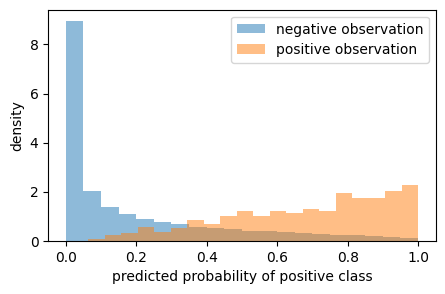

In [9]:
plt.figure(figsize=(5, 3))
plt.hist(negatives, label="negative observation", alpha=0.5, bins=20, density=True)
plt.hist(positives, label="positive observation", alpha=0.5, bins=20, density=True)
plt.xlabel("predicted probability of positive class")
plt.ylabel("density")
plt.legend();

In [10]:
auprc_df: pd.DataFrame = pd.DataFrame(auprc_df)

In [11]:
auprc_df["true"].describe().round(3)

count    500.000
mean       0.114
std        0.008
min        0.089
25%        0.108
50%        0.113
75%        0.119
max        0.143
Name: true, dtype: float64

Make a dataframe of paired errors for each estimator

In [12]:
error_df = dict()  # signed
_error_column_prefix = "error "
for estimator in auprc_df.columns:
    if estimator == "true":
        continue
    error_df[f"{_error_column_prefix}{estimator}"] = (
        auprc_df[estimator] - auprc_df["true"]
    )
error_df: pd.DataFrame = pd.DataFrame(error_df)

In [13]:
print(error_df.describe().round(3))  # print for easy copy-paste

       error down-sample  error repeat  error up-sample  error re-weigh
count            500.000       500.000          500.000         500.000
mean              -0.021         0.009           -0.002           0.009
std                0.041         0.027            0.020           0.027
min               -0.094        -0.042           -0.047          -0.042
25%               -0.050        -0.010           -0.015          -0.010
50%               -0.031         0.004           -0.005           0.004
75%                0.001         0.024            0.009           0.024
max                0.220         0.113            0.066           0.113


In [14]:
(error_df > 0).mean()

error down-sample    0.260
error repeat         0.568
error up-sample      0.384
error re-weigh       0.568
dtype: float64

As expected, down-sampling incurs really high variance b/c it's only looking at a
handful of positive cases. Don't ask me why it's so biased.

In [15]:
# error_df.plot.hist(
#     bins=20,
#     alpha=1/len(error_df.columns),
#     xlabel="error",
#     ylabel="frequency",
#     title="AUPRC estimator error distributions",
# );

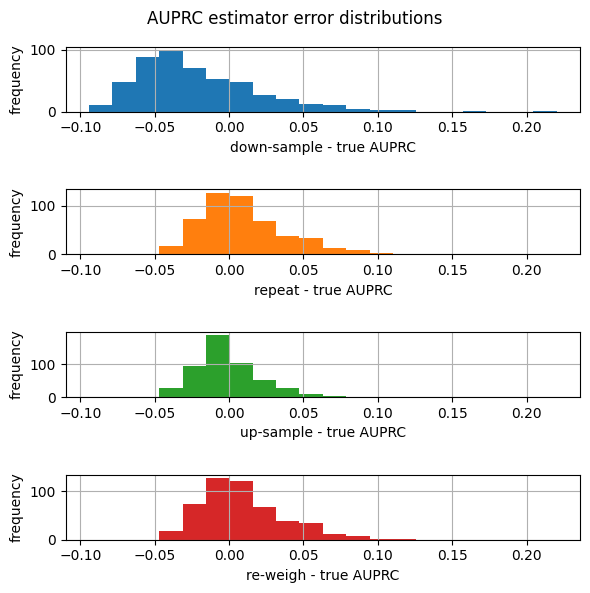

In [16]:
bins = 20

fig, axes = plt.subplots(
    nrows=len(error_df.columns), ncols=1, figsize=(6, len(error_df.columns) * 1.5)
)

_common_min = error_df.min().min()
_common_max = error_df.max().max()
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Plot histograms for each column
for i, column in enumerate(error_df.columns):
    error_df[column].hist(
        bins=bins, ax=axes[i], range=(_common_min, _common_max), color=colors[i]
    )
    estimator = column.removeprefix(_error_column_prefix)
    axes[i].set_xlabel(f"{estimator} - true AUPRC")
    axes[i].set_ylabel("frequency")

fig.suptitle("AUPRC estimator error distributions", fontsize=12)
plt.tight_layout()
plt.subplots_adjust(hspace=1.2)